In [1]:
import sys
import time
import numpy as np
import pylab as pl
import tables as pytb
import os

sys.path.append('../') # get out of the sandbox

from vent.controller.control_module import get_control_module, Balloon_Simulator
from vent.common.message import SensorValues, ControlSetting
from vent.common.values import ValueName, CONTROL

In [2]:
os.chdir('../');
Controller = get_control_module(sim_mode=True)

In [3]:
Controller.start()

ls = []
tt = []
t0 = time.time()
for t in np.arange(0, 10,0.05):
    
    if t%5==0:  # ask for a heartbeat from thread every 5 seconds
        print(t)
    
    
    ## Do things
    command = ControlSetting(name=ValueName.PEEP, value=3, min_value=1, max_value=4, timestamp=time.time())
    Controller.set_control(command)

    command = ControlSetting(name=ValueName.PIP, value=40, min_value=38, max_value=42, timestamp=time.time())
    Controller.set_control(command)

    command = ControlSetting(name=ValueName.BREATHS_PER_MINUTE, value=20, min_value=19, max_value=21, timestamp=time.time()) 

    Controller.set_control(command)

    v_iphase = 0.4 * 60/20  #0.3 and 0.8
    command = ControlSetting(name=ValueName.INSPIRATION_TIME_SEC, value=v_iphase, min_value=v_iphase - 1, max_value=v_iphase + 1, timestamp=time.time())
    Controller.set_control(command)
    
    ##
    
    
    vals = Controller.get_sensors()
    ls.append(vals)
    tt.append(time.time()  - t0)
    
    time.sleep(0.05)
    
Controller.stop()

0.0
5.0


In [4]:
# Get the target waveform, and plot together with the last measured waveform

In [4]:
pas_wv = Controller.get_past_waveforms()
wv = Controller.get_target_waveform()

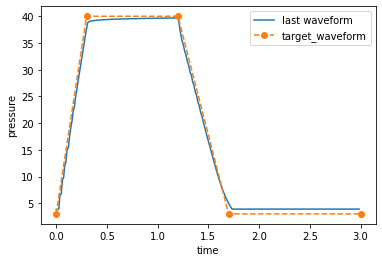

In [5]:
lastwv = pas_wv[-1]
pl.plot(lastwv[:,0], lastwv[:,1], label='last waveform')
pl.plot([pt[0] for pt in wv], [pt[1] for pt in wv], '--o', label = 'target_waveform')
pl.legend()
pl.xlabel('time')
pl.ylabel("pressure");

In [7]:
# Subsampled data

Text(0.5, 0, 'time [s]')

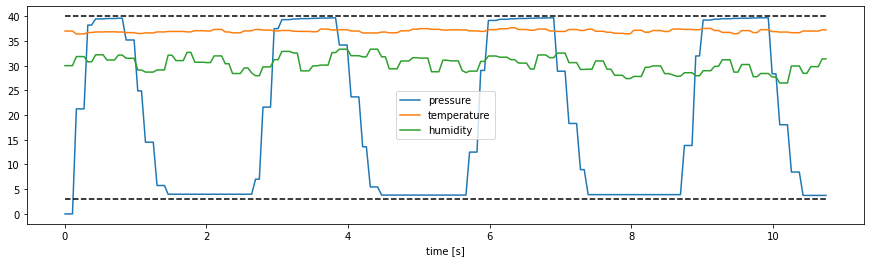

In [6]:
pl.rcParams['figure.figsize'] = [15, 4]

cc = Controller.get_control(control_setting_name = ValueName.PEEP)
peep = cc.value

cc = Controller.get_control(control_setting_name = ValueName.PIP)
pip = cc.value

pl.plot(tt, [s.PRESSURE for s in ls], label = 'pressure')
pl.plot(tt, [s.TEMP for s in ls], label = "temperature")
pl.plot(tt, [s.HUMIDITY/3 for s in ls], label = "humidity")
pl.plot([np.min(tt), np.max(tt)], [pip, pip], 'k--')
pl.plot([np.min(tt), np.max(tt)], [peep, peep], 'k--')
    
pl.legend()
pl.xlabel("time [s]")

In [7]:
dff = Controller.dl.load_file()

Reading... vent/logfiles/2020-05-21-17-28_controller_log.h5


In [10]:
ls_wv = dff['waveform_data']
ls_ct = dff['control_data']

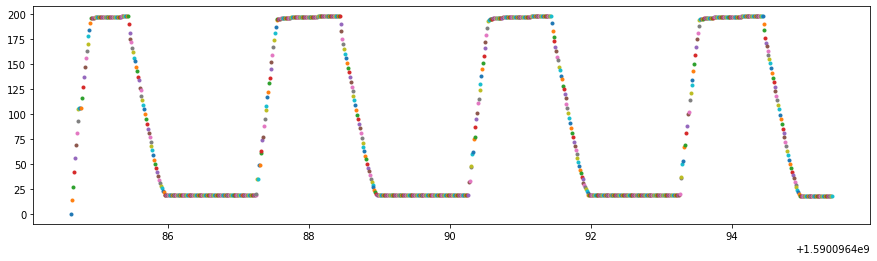

In [11]:
for p in ls_wv:
    pl.plot(p[4], p[3],'.') #pressure

In [1]:
import numpy as np
import pylab as pl

In [7]:
data = np.load("/Users/ms81/data_4.npy")
r = data[:,0]>0

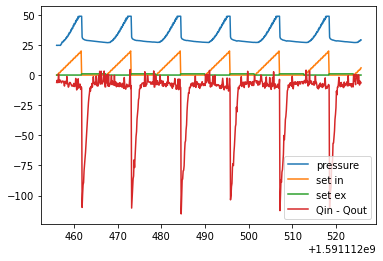

In [8]:
pl.plot(data[r,0], data[r,1],'-', label = "pressure")
pl.plot(data[r,0], data[r,2],'-', label = "set in")
pl.plot(data[r,0], data[r,3],'-', label = "set ex") 
pl.plot(data[r,0], data[r,4] -data[r,5] ,'-', label = "Qin - Qout") 
pl.legend()

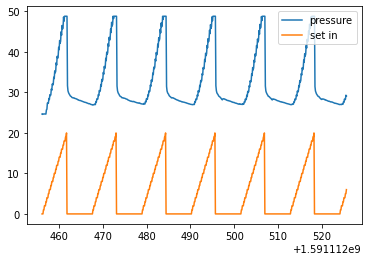

In [10]:
pl.plot(data[r,0], data[r,1],'-', label = "pressure")
pl.plot(data[r,0], data[r,2],'-', label = "set in")
# pl.plot(data[r,0], data[r,3],'-', label = "set ex") 
# pl.plot(data[r,0], data[r,4] -data[r,5] ,'-', label = "Qin - Qout") 
pl.legend()

In [ ]:
PEEP: 30
    PIP: 48

In [30]:
np.max(data[:,3])

0.0

In [17]:
from vent.controller.control_module import get_control_module

from vent.common.logging import DataLogger

dl = DataLogger()

In [ ]:
ms81@pni-18c02xj50tjgh5 ~ % cp ./mntpi/vent/logs/2020-06-02-15-48_controller_log.0.h5 ./
ms81@pni-18c02xj50tjgh5 ~ % cp ./mntpi/vent/logs/2020-06-02-15-50_controller_log.0.h5 ./

In [162]:
# dff = dl.load_file("../../2020-06-02-15-46_controller_log.0.h5") #with three things
# dff = dl.load_file("../../2020-06-02-15-48_controller_log.0.h5") #without
# dff = dl.load_file("../../2020-06-02-15-50_controller_log.0.h5") #only
dff = dl.load_file("../../2020-06-02-16-21_controller_log.0.h5") #only

Reading... ../../2020-06-02-16-21_controller_log.0.h5


In [163]:
ls_wv = dff['waveform_data']
ls_ct = dff['control_data']

In [164]:
ls_wv

array([(  0, -6.6666670e-02,   17.018396, -0.52605927, 1.59112928e+09),
       (  0, -3.3333335e-02,   11.610528, -0.56121033, 1.59112928e+09),
       (  0,  6.6666670e-02, -116.39391 , -2.5648215 , 1.59112928e+09),
       ...,
       (113, -1.0913333e+02,    8.760497,  9.491997  , 1.59112974e+09),
       (113, -1.0246667e+02,    9.803009,  8.859277  , 1.59112974e+09),
       (113, -1.0026667e+02,    8.760497,  8.367162  , 1.59112974e+09)],
      dtype=[('cycle_number', '<u4'), ('flow_in', '<f4'), ('flow_out', '<f4'), ('pressure', '<f4'), ('timestamp', '<f8')])

In [170]:
data = np.zeros((len(ls_wv),2))
for idx in range(len(ls_wv)):
    data[idx,0] = ls_wv[idx][4]
    data[idx,1] = ls_wv[idx][3]

(200.0, 210.0)

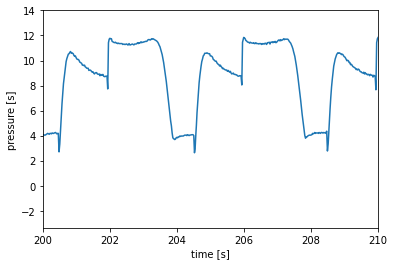

In [174]:
pl.plot(data[:,0] - np.min(data[:,0]), data[:,1])
pl.xlabel("time [s]")
pl.ylabel("pressure [s]")
pl.xlim([200,210])

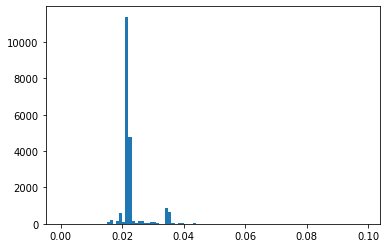

In [182]:
pl.hist(np.diff(data[:,0]), np.arange(0,0.1,0.001));

In [175]:
how can the logfile not contain a 32??

array([(nan, nan, b'ValueName.PEEP', nan,  5. ),
       (nan, nan, b'ValueName.PIP', nan, 25. ),
       (nan, nan, b'ValueName.PIP_TI', nan,  0.5), ...,
       (nan, nan, b'ValueName.PIP_TI', nan,  0.5),
       (nan, nan, b'ValueName.BREATH', nan, 15. ),
       (nan, nan, b'ValueName.INSPIR', nan,  1.5)],
      dtype=[('max_value', '<f8'), ('min_value', '<f8'), ('name', 'S16'), ('timestamp', '<f8'), ('value', '<f8')])